# Capstone Project - The Battle of Neighbourhoods (Week 1 & 2)
<h2><center>Property Prices & Venue Data Analysis of London</center></h2>


## 1. Introduction

### 1.1. Background
It goes without saying that the coronavirus (COVID-19) has had, is currently and will continue to have a significant impact on businesses and the economy worldwide. This is evident with stock market and oil prices crash, record breaking number of people filing for unemployment and major airlines on the brink of adminstration.

The Real Estate & Property market is no exception to the coronavirus impact, with the London property market coming to a halt back in March when the full lock down was announced to prevent the spread of the virus. Physical viewings were postponed, constructions were suspended and estate agents & morgage lenders no longer able to value properties in person.

As a result Zoopla has predicted that completed sales in the UK will be 50% lower in 2020 than in 2019 and Knight Frank has also predicted that the number of sales in Greater London will fall by 35%. However despite the bleak outlook for property and housing prices this year, a large number of firms & their analysts believe that the housing market could make a very strong recovery by 2021, with an estimated range of 3% - 6%.

### 1.2. Business Problem
The best decisions are often backed up by insight and data,  by utilising Machine Learning we can effectively and efficiently generate those insights in order to provide potential home-buyers and investors the best decision making support as possible. This brings us to our business problem: How can we generate insight so home-buyers and investors can make well informed choices when purchasing properties in London, especially in this uncertain economic situation?

In order to solve this business problem, we will cluster the London areas based on the average sales price, local venues and amenities, i.e. schools, supermarkets, coffee shops. We will then compare these clusters with the average property prices and rental prices for each borough, and also calculate the rental yield for each cluster for investors who are buying to let. This will provide valuable information on whether a property is a viable choice for home-buyers & investors.

## 2. Data Acquisition

### 2.1. Data Sources

The Price Paid Data (property sales data) in London will be sourced from HM Land REgistry, where the data is based on the raw data released each month. The dataset will include the following columns: Transaction unique identifier, Price, Date of Transfer, Postcode, Property Type, Old/New, Duration, PAON (Primary Addressable Object Name), SAON (Secondary Addressable Object Name), Street, Locality, Town/City, District, County and PPD Category Type.

The FourSquare API will be used to access and explore venues and amenities based on the Latitude and Longitude collected using the GeoCoder library, which will then be read into a dataframe for data wrangling and cleaning. This dataframe will be merged with the Price Paid Data from HM Land Registry and processed to be suitable for fitting the machine learning model.

The list of boroughs in London will be scrapped from the Wikipedia page and the average property and rental prices per borough will be scraped from Foxtons (A UK estate agency). The data will be visualised using Folium in order to gauge the recommendations generated by our model against average prices for each cluster.

Please see the References section at the end of the notebook for links and descriptions for data sources.

### 2.2. Data Collecting & Cleaning

In [1]:
import pandas as pd
import numpy as np
import json
import csv
import re
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium
import plotly.express as px
print('Libraries imported.')

Libraries imported.


#### Price Paid Data

In [2]:
ppd_2019 = pd.read_csv('../data/external/pp-2019.csv')
ppd_2019.head()

,{8F1B26BD-60CA-53DB-E053-6C04A8C03649},221950,2019-04-26 00:00,TS17 5FF,D,Y,F,3,Unnamed: 8,CARRAWBURGH ROAD,INGLEBY BARWICK,STOCKTON-ON-TEES,STOCKTON-ON-TEES.1,STOCKTON-ON-TEES.2,A,A.1
0,{8F1B26BD-60CB-53DB-E053-6C04A8C03649},246995,2019-03-29 00:00,TS15 9ZH,D,Y,F,16,NaN,GRESLEY CLOSE,NaN,YARM,STOCKTON-ON-TEES,STOCKTON-ON-TEES,A,A
1,{8F1B26BD-60CC-53DB-E053-6C04A8C03649},244950,2019-05-17 00:00,TS18 2FN,T,Y,F,13,NaN,INFINITY VIEW,NaN,STOCKTON-ON-TEES,STOCKTON-ON-TEES,STOCKTON-ON-TEES,A,A
2,{8F1B26BD-60CD-53DB-E053-6C04A8C03649},139950,2019-05-31 00:00,TS18 2FN,S,Y,F,40,NaN,INFINITY VIEW,NaN,STOCKTON-ON-TEES,STOCKTON-ON-TEES,STOCKTON-ON-TEES,A,A
3,{8F1B26BD-60CE-53DB-E053-6C04A8C03649},271995,2019-05-31 00:00,TS15 9FD,D,Y,F,27,NaN,MALLARD DRIVE,NaN,YARM,STOCKTON-ON-TEES,STOCKTON-ON-TEES,A,A
4,{8F1B26BD-60CF-53DB-E053-6C04A8C03649},84450,2019-04-26 00:00,TS18 2FD,T,Y,F,117,NaN,DEEPDALE AVENUE,NaN,STOCKTON-ON-TEES,STOCKTON-ON-TEES,STOCKTON-ON-TEES,A,A


As mentioned on the 'How to access HM Land Registry Price Paid Data' website, the column headers are not supplied in the file therefore they will need to be manually added.

In [3]:
ppd_2019.columns = ['TUID', 'Price', 'Date_of_Transfer', 'Postcode', 'Property_Type', 'Old_New', 'Duration',
                    'PAON', 'SAON', 'Street', 'Locality', 'Town_City', 'District', 'County', 'PPD_Cat_Type', 'Record_Status']

ppd_2019.sort_values(by=['Date_of_Transfer'], ascending=False, inplace=True)
ppd_2019.head()

,TUID,Price,Date_of_Transfer,Postcode,Property_Type,Old_New,Duration,PAON,SAON,Street,Locality,Town_City,District,County,PPD_Cat_Type,Record_Status
908444,{9DBAD222-BE41-6EB3-E053-6B04A8C0F257},155000,2019-12-31 00:00,LS28 8ED,S,N,F,445,NaN,BRADFORD ROAD,NaN,PUDSEY,LEEDS,WEST YORKSHIRE,B,A
415790,{9DBAD222-8F5A-6EB3-E053-6B04A8C0F257},19476811,2019-12-31 00:00,WA5 3UZ,O,N,L,NORTH WEST FIRE & CONTROL CENTRE,NaN,LINGLEY GREEN AVENUE,LINGLEY MERE BUSINESS PARK,WARRINGTON,WARRINGTON,WARRINGTON,B,A
921591,{A2479555-56B8-74C7-E053-6B04A8C0887D},294000,2019-12-31 00:00,SP11 6ZQ,T,Y,F,50,NaN,CASHMERE DRIVE,NaN,ANDOVER,TEST VALLEY,HAMPSHIRE,A,A
902369,{9DBAD222-B849-6EB3-E053-6B04A8C0F257},67500,2019-12-31 00:00,SA11 2HG,T,N,F,10,NaN,PENRHIWTYN STREET,NaN,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT,B,A
885654,{9FF0D969-B57B-11ED-E053-6C04A8C06383},176000,2019-12-31 00:00,M46 9EF,S,N,L,43,NaN,CHANTERS AVENUE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,A,A


#### List of London Boroughs

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(source)
table = soup.find('table',class_='wikitable sortable')
tr_elements = soup.find_all(['tr'])[0:34]

# Write the table headers and cells into a CSV
with open('../data/raw/london_boroughs.csv', 'w', newline='', encoding='utf-8') as f:
    column_headers = ['Borough','Inner','Status', 'Local authority', 'Political control',
                      'Headquarters', 'Area (sq_mi)', 'Population (2013_est)', 'Coordinates', 'Nr in map']
    writer = csv.writer(f)
    writer.writerow(column_headers)
    for cell in tr_elements:
            td = cell.find_all('td')
            row = [i.text.replace('\n','').replace(' / ',',') for i in td]
            writer.writerow(row)

There were 3 boroughs that were scraped with citation reference text, '[note #]', so those were removed by chaining .replace methods. The latitude and longitdue were also sliced out of the Coordinates column and assigned each to their own respected columns.

In [5]:
london_boroughs = pd.read_csv('../data/raw/london_boroughs.csv', usecols=['Borough', 'Coordinates'])
london_boroughs['Latitude'] = london_boroughs['Coordinates'].str[43:50]
london_boroughs['Longitude'] = london_boroughs['Coordinates'].str[52:60]
london_boroughs['Borough'] = [b.replace('[note 1]', '').replace('[note 4]', '').replace('[note 2]', '') for b in london_boroughs['Borough'] ]
london_boroughs

,Borough,Coordinates,Latitude,Longitude
0,Barking and Dagenham,"51°33′39″N 0°09′21″E﻿,﻿51.5607°N 0.1557°E﻿,51....",51.5607,0.1557﻿
1,Barnet,"51°37′31″N 0°09′06″W﻿,﻿51.6252°N 0.1517°W﻿,51....",51.6252,-0.1517﻿
2,Bexley,"51°27′18″N 0°09′02″E﻿,﻿51.4549°N 0.1505°E﻿,51....",51.4549,0.1505﻿
3,Brent,"51°33′32″N 0°16′54″W﻿,﻿51.5588°N 0.2817°W﻿,51....",51.5588,-0.2817﻿
4,Bromley,"51°24′14″N 0°01′11″E﻿,﻿51.4039°N 0.0198°E﻿,51....",51.4039,0.0198﻿
5,Camden,"51°31′44″N 0°07′32″W﻿,﻿51.5290°N 0.1255°W﻿,51....",51.5290,-0.1255﻿
6,Croydon,"51°22′17″N 0°05′52″W﻿,﻿51.3714°N 0.0977°W﻿,51....",51.3714,-0.0977﻿
7,Ealing,"51°30′47″N 0°18′32″W﻿,﻿51.5130°N 0.3089°W﻿,51....",51.5130,-0.3089﻿
8,Enfield,"51°39′14″N 0°04′48″W﻿,﻿51.6538°N 0.0799°W﻿,51....",51.6538,-0.0799﻿
9,Greenwich,"51°29′21″N 0°03′53″E﻿,﻿51.4892°N 0.0648°E﻿,51....",51.4892,0.0648﻿


#### Property and Rental Prices 

Next I scraped a list of London postcodes and their corresponding districts from the following website: https://www.doogal.co.uk/london_postcodes.php. Using the postcode I then scraped the average property prices and rental prices from the Foxton website. All the data is written into a CSV file.

In [27]:
with open('../data/raw/london_property_prices.csv', 'w', newline='', encoding='utf-8') as f:
    column_headers = ['postcode','districts', 'avg_property_price','avg_rental_price']
    writer = csv.DictWriter(f, fieldnames = column_headers)
    writer.writeheader()
    
    # Scrape postcodes and districts 
    source_postcode = requests.get('https://www.doogal.co.uk/london_postcodes.php').text
    soup1 = BeautifulSoup(source_postcode)
    districts = soup1.find('div', class_='realContent')
    a_elements = districts.find_all('a')[43:157]
    for i in range(len(a_elements)):
        Postcode = a_elements[i].getText().split(':')[0]
        Districts= a_elements[i].getText().split(': ')[1]
        i += 1
        
        # Scrape the prices for each postcode obtained above
        source_foxtons = requests.get('https://www.foxtons.co.uk/living-in/{}'.format(Postcode)).text
        soup2 = BeautifulSoup(source_foxtons)
        var_elements = soup2.find_all(['var'], class_="price_headline")
        property_price = var_elements[0].getText()[1:]
        rental_price = var_elements[1].getText()[1:]
        # Return NaN if there is no data for rental prices
        if len(rental_price) > 1:
            result = re.search('[0-9A-Fa-f,]+', rental_price).group()
        else:
            result = 'NaN'
            
        # Write all of the above into the CSV    
        writer.writerow({'postcode': Postcode, 'districts':Districts,
                         'avg_property_price':property_price, 'avg_rental_price':result})

In [28]:
london_property_prices = pd.read_csv('../data/raw/london_property_prices.csv')
london_property_prices.head()

,postcode,districts,avg_property_price,avg_rental_price
0,E1,"Mile End, Stepney, Whitechapel","659,278",481
1,E2,"Bethnal Green, Shoreditch","454,292",655
2,E3,"Bow, Bromley-by-Bow","490,185",473
3,E4,"Chingford, Highams Park","409,644",325
4,E5,Clapton,"662,577",514


### 2.3. Feature Selection 

From the Price Paid Data, most of the columns were dropped as they were not relevant in our business problem, such as TUID, Duration, PAON, SAON, Locality, PPD_Cat_Type and Record_Status. 

There were also a number of rows where the prices where very high, which could have been a commerical property. Therefore rows where the price is larger than £2,000,000 were also dropped.

In [4]:
ppd_2019_clean = ppd_2019.drop(columns=['TUID', 'Duration', 'PAON', 'SAON', 'Locality', 'PPD_Cat_Type', 'Record_Status'])

# Filter out rows where Town_City column contains 'LONDON'
ppd_london = ppd_2019_clean[ppd_2019['Town_City']=='LONDON']
ppd_london = ppd_london.drop(ppd_london[ppd_london.Price > 2000000].index)
ppd_london.head()

,Price,Date_of_Transfer,Postcode,Property_Type,Old_New,Street,Town_City,District,County
918996,600000,2019-12-31 00:00,SW18 1UX,F,Y,OSIERS ROAD,LONDON,WANDSWORTH,GREATER LONDON
737743,600000,2019-12-31 00:00,SW18 1UX,F,Y,OSIERS ROAD,LONDON,WANDSWORTH,GREATER LONDON
737745,495000,2019-12-31 00:00,SW18 1UX,F,Y,OSIERS ROAD,LONDON,WANDSWORTH,GREATER LONDON
714996,600000,2019-12-31 00:00,SW18 1UX,F,Y,OSIERS ROAD,LONDON,WANDSWORTH,GREATER LONDON
956199,910000,2019-12-31 00:00,SE1 7HD,F,N,ALBERT EMBANKMENT,LONDON,LAMBETH,GREATER LONDON


In [5]:
ppd_grouped = ppd_london.groupby(['Street'])['Price'].mean().round(0).reset_index()
ppd_grouped.columns = ['street', 'avg_price']
ppd_grouped.sort_values(by=['avg_price'], inplace=True)
ppd_grouped

,street,avg_price
9244,PEMBRIDGE ROAD,100.0
12772,WEYMOUTH MEWS,100.0
7179,LEESIDE CRESCENT,380.0
3756,DOWNS COURT PARADE,1000.0
900,BEACONSFIELD PARADE,1000.0
...,...,...
7322,LINDEN LEA,2000000.0
6231,HOLYWELL ROW,2000000.0
5959,HERONDALE AVENUE,2000000.0
3173,CRAVEN HILL MEWS,2000000.0


Now we filter out rows from the ppd_2019_clean dataframe where the Town is 'LONDON', then we group the dataframe by the street names and find the average price paid for property on those streets.

As there are a large number of rows, getting the latitude, longitude and FourSquare data for each row/street will take a significant amount of time. A Python script will be used to get all the latitude and longitude, write them to a CSV file, and the resulting dataset will then be separated into 4 bands based on the average price, increasing by £25,000 in the first three band and by £100,000 in the last band. 

This will decrease the computional time required and provide us with an overview of properties and their nearby venues across different pricing ranges.

In [6]:
ppd_london_2019 = pd.read_csv('../data/processed/ppd_london_2019.csv')
ppd_london_2019 = ppd_london_2019[ppd_london_2019.latitude != 'Nan']
ppd_london_2019.shape

(12610, 4)

In [7]:
ppd_london_2019['latitude'] = pd.to_numeric(ppd_london_2019['latitude'], downcast="float")
ppd_london_2019['longitude'] = pd.to_numeric(ppd_london_2019['longitude'], downcast="float")
ppd_london_2019.head()

,street,avg_price,latitude,longitude
0,ABBESS CLOSE,296000,51.515453,0.049416
1,ABBEVILLE ROAD,613870,51.453304,-0.140988
2,ABBEY GARDENS,1473800,51.484844,-0.213365
3,ABBEY GROVE,350000,51.490322,0.115759
4,ABBEY PARADE,596200,51.531391,-0.292546


In [8]:
ppd_band1 = ppd_london_2019.query('(avg_price > 250000) & (avg_price <= 275000)')
ppd_band2 = ppd_london_2019.query('(avg_price > 500000) & (avg_price <= 525000)')
ppd_band3 = ppd_london_2019.query('(avg_price > 750000) & (avg_price <= 775000)')
ppd_band4 = ppd_london_2019.query('(avg_price > 1000000) & (avg_price <= 1100000)')

print(ppd_grouped.shape)
print('Band 1:', ppd_band1.shape)
print('Band 2:', ppd_band2.shape)
print('Band 3:', ppd_band3.shape)
print('Band 4:', ppd_band4.shape)

(13272, 2)
Band 1: (272, 4)
Band 2: (464, 4)
Band 3: (225, 4)
Band 4: (360, 4)


In [9]:
ppd_london_bands = ppd_band1.append([ppd_band2, ppd_band3, ppd_band4], ignore_index=True)
print(ppd_london_bands.shape)
ppd_london_bands.head()

(1321, 4)


,street,avg_price,latitude,longitude
0,ABBEYFIELD ROAD,265000,51.491352,-0.053131
1,ACTON CLOSE,271000,51.627186,-0.061062
2,ALBATROSS CLOSE,265000,51.518841,0.058978
3,ALDWORTH GROVE,251000,51.451118,-0.014584
4,ALFREDA STREET,262250,51.474522,-0.150164


## 3. Exploratory Data Analysis (EDA)

### 3.1. Price Paid Data

Let's visualise the average property prices for those streets by plotting them on a map.

In [10]:
geolocator = Nominatim(user_agent='london_explorer')
location = geolocator.geocode('London, UK')
latitude_ldn = location.latitude
longitude_ldn = location.longitude
print('The geographical coordinate of London, UK are {}, {}.'.format(latitude_ldn, longitude_ldn))

The geographical coordinate of London, UK are 51.5073219, -0.1276474.


In [13]:
mapbox_access_token = (open("../secrets/mapbox_token.txt").read())

fig = px.scatter_mapbox(ppd_london_2019, lat="latitude", lon="longitude", size="avg_price", color="avg_price",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=6)
fig.update_layout(
    title='Property Paid Price in London 2019',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=latitude_ldn,
            lon=longitude_ldn
        ),
        pitch=5,
        zoom=10,
        style='light'
    ),
)
fig.show()

As expected, neighbourhoods such as Mayfair, Chelsea, Knightsbridge, Notting Hill and Fulham have the highest average property prices. We can also see from the map above that more expensive properties are mostly located on the west side of central London, and compared to the east side there are far fewer properties that exceed the £1,000,000 mark. However there are exceptions, with a small cluster near Blackheath, Canary Wharf, Newbury Park and Bexleyheath.

This will be useful to home-buyers or investors as they may take into consideration a neighbourhood that they were not aware of previously. The next step would be to explore the said neighbourhoods using the FourSquare API.

### 3.2. Explore the area and nearby venues

Let's take a look at the first neighbourhood and it's nearby venues.

In [13]:
secret_dict = {}
with open('../secrets/foursquare_secrets.txt') as f:
    for item in f:
        (key, val) = item.split(':')
        secret_dict[key] = val.strip('\n')

In [14]:
LIMIT = 100
radius = 500
VERSION = '20180605'
neighborhood_latitude = ppd_london_2019.loc[7714, 'latitude']
neighborhood_longitude = ppd_london_2019.loc[7714, 'longitude']
neighborhood_name = ppd_london_2019.loc[7714, 'street']
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(secret_dict.get('client_id'), secret_dict.get('client_secret'), neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Bake Street,Coffee Shop,51.558766,-0.066750
1,The Well Garden,Yoga Studio,51.554617,-0.066698
2,Rectory Road Railway Station (REC),Train Station,51.558868,-0.068506
3,Royal Sovereign,Pub,51.562788,-0.063242
4,Stoke Newington Bus Stand,Bus Station,51.561264,-0.070025
5,Ming,Chinese Restaurant,51.562833,-0.061966
6,El Garito,Cocktail Bar,51.554715,-0.066973
7,The Village Green,Market,51.554646,-0.066840


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


#### Now we repeat what we have done above for all the other neighbourhoods by creating a function that repeat the same process.

The function below takes in 3 variables and 1 default variable, it then loops over each row in the datafraem and sends the API call to FourSquare. The JSON data returned is then processed to extract the data that we are after, in this case they are Venue name, Venue latitude, Venue longitude and Venue category. Finally the data is written into a dataframe.

In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            secret_dict.get('client_id'), 
            secret_dict.get('client_secret'), 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Street', 
                  'Street Latitude', 
                  'Street Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Initially a for loop was using to run the function above over the 4 price band dataframes. However the script kept running into an error where the the key 'groups' was not found within the json response. Upon investigation this error, the function did not have an issue if the rows in question were isolated and the script re-ran, nor was it related to the FourSquare API rate limits. In the end, in order to overcome that error the function was ran separately on the 4 dataframes.

In [50]:
band1_venues = getNearbyVenues(names=ppd_band1['street'],
                            latitudes=ppd_band1['latitude'],
                            longitudes=ppd_band1['longitude']
                            )
band1_venues.groupby('Street')['Venue'].count()

ABBEYFIELD ROAD
ACTON CLOSE
ALBATROSS CLOSE
ALDWORTH GROVE
ALFREDA STREET
AMSTERDAM ROAD
ANTHONY ROAD
ARCH STREET
ARKLEY ROAD
AUCKLAND RISE
AVENUE GARDENS
AYRES CLOSE
BAILDON STREET
BARFIELD AVENUE
BARNEY CLOSE
BAROQUE GARDENS
BARROWFIELD CLOSE
BARSON CLOSE
BAYHAM PLACE
BEACON GATE
BEECH COURT
BELL GREEN LANE
BERNARD ASHLEY DRIVE
BERNWELL ROAD
BESANT WAY
BOLTON CRESCENT
BOUVERIE PLACE
BOWER STREET
BRAMHOPE LANE
BRANDON ESTATE
BRENDON GROVE
BRIXTON STATION ROAD
BROAD LANE
BROCKLEY VIEW
BROOK SQUARE
BRYMAY CLOSE
BUCKSTONE ROAD
BULWER COURT
BUTE STREET
BUXTON CLOSE
CAIRNS AVENUE
CAISTOR MEWS
CAMPSHILL ROAD
CANDLE STREET
CAPSTAN WAY
CAPULET SQUARE
CAROLINE CLOSE
CASTILE ROAD
CHADWIN ROAD
CHARDWELL CLOSE
CHERRY BLOSSOM CLOSE
CHESEMAN STREET
CHESTERTON TERRACE
CLARENCE LANE
CLEM ATTLEE COURT
CLIFF ROAD
CLIFFORD DRIVE
CLYSTON STREET
COATE STREET
COBORN ROAD
COE AVENUE
COLEBERT AVENUE
COLLIER CLOSE
COLYER CLOSE
CONGLETON GROVE
CONISTON CLOSE
COOKES CLOSE
COSGROVE CLOSE
COVERACK CLOSE
CRAVEN PA

Street
ABBEYFIELD ROAD           17
ACTON CLOSE               20
ALBATROSS CLOSE            9
ALDWORTH GROVE            15
ALFREDA STREET            24
                          ..
WOODLAND GROVE            30
WOOLWICH CHURCH STREET     4
WORSLEY BRIDGE ROAD        4
WYTHFIELD ROAD            24
YUNUS KHAN CLOSE          13
Name: Venue, Length: 271, dtype: int64

In [51]:
band2_venues = getNearbyVenues(names=ppd_band2['street'],
                            latitudes=ppd_band2['latitude'],
                            longitudes=ppd_band2['longitude']
                            )
band2_venues.groupby('Street')['Venue'].count()

ADDERLEY GROVE
ADMIRALS WAY
AGATON ROAD
ALBION ROAD
ALDIS STREET
ALEXANDRA DRIVE
AMBLER ROAD
ARCHERY STEPS
ARCHWAY MEWS
ARGYLE SQUARE
ARLOW ROAD
ARMOURY WAY
ARNOLD ROAD
ARRAN ROAD
ASH GROVE
ASH ROAD
ASHMORE CLOSE
ASPEN CLOSE
ASTBURY ROAD
ATHERFOLD ROAD
ATHOL SQUARE
AUCKLAND ROAD
AXMINSTER ROAD
BAKERS END
BALHAM GROVE
BALLARDS LANE
BANSTEAD GARDENS
BARRINGTON ROAD
BEACONSFIELD ROAD
BEECHFIELD ROAD
BELFORT ROAD
BELITHA VILLAS
BENHILL ROAD
BERESFORD AVENUE
BERTRAM ROAD
BEVERLEY COURT
BILLINGHURST WAY
BIRCHEN GROVE
BLACKTHORNE DRIVE
BLINCOE CLOSE
BLOMFIELD VILLAS
BLYTHE VALE
BODMIN STREET
BONNINGTON SQUARE
BOUNDARY ROAD
BOURNE GARDENS
BOYD STREET
BRAMCOTE GROVE
BRANCH PLACE
BRANDRAM ROAD
BRASSEY ROAD
BRAVINGTON ROAD
BREAKSPEARS ROAD
BREMER MEWS
BRENTMEAD PLACE
BRETT ROAD
BRIDGE LANE
BRIDGEWOOD ROAD
BRINDWOOD ROAD
BRITTON STREET
BROADWAY MARKET
BROWNS ROAD
BULLEN STREET
BUNYAN ROAD
BURNLEY ROAD
BYNE ROAD
BYRON ROAD
CADOGAN CLOSE
CADWALLON ROAD
CALDERON ROAD
CAMPBELL ROAD
CARLYLE ROAD
CARNAR

Street
ADDERLEY GROVE       6
ADMIRALS WAY         4
AGATON ROAD          7
ALBION ROAD         37
ALDIS STREET        26
                    ..
WOODCOTE AVENUE      8
WOODS ROAD          29
WOODSTOCK GROVE     82
WORCESTER AVENUE    20
WORSLEY ROAD         7
Name: Venue, Length: 460, dtype: int64

In [53]:
band3_venues = getNearbyVenues(names=ppd_band3['street'],
                            latitudes=ppd_band3['latitude'],
                            longitudes=ppd_band3['longitude']
                            )
band3_venues.groupby('Street')['Venue'].count()

ABBOTSHADE ROAD
ADOLPHUS ROAD
ALDENSLEY ROAD
ALLISON ROAD
AMBERDEN AVENUE
ANTILL ROAD
ARBERY ROAD
ARRAGON GARDENS
ASHBOURNE GROVE
ATTWOOD LANE
AUBERT PARK
AVENING ROAD
BARCLAY ROAD
BAXENDALE
BEAUCLERC ROAD
BEAUMONT STREET
BECKWITH ROAD
BELLEVUE ROAD
BERMONDSEY STREET
BEVERLEY ROAD
BEWDLEY STREET
BIRCHINGTON ROAD
BLOOMSBURY WAY
BONNEVILLE GARDENS
BOURNE HILL
BRAMPTON GROVE
BRATHWAY ROAD
BRIARBANK ROAD
BRIARFIELD AVENUE
BRISTON GROVE
BROCKLEY ROAD
BROWNING ROAD
BUCKINGHAM ROAD
CANNING CROSS
CARDINALS WAY
CATHERINE GROVE
CEDARHURST DRIVE
CHALFONT WAY
CHAMBERLAIN ROAD
CHAMBERLAYNE ROAD
CHANCELLORS WHARF
CHARLES STREET
CHASEFIELD ROAD
CHELSEA TOWERS
CHESSON ROAD
CHESTNUT DRIVE
CHEVERTON ROAD
CHISWICK HIGH ROAD
CHOUMERT ROAD
CHURCH WAY
CHURSTON GARDENS
CLAIRVIEW ROAD
CLIFTON ROAD
COLOSSEUM TERRACE
CONEY ACRE
COOPERS LANE
CORNTHWAITE ROAD
CORONET STREET
CRAVEN HILL GARDENS
CRAVEN ROAD
CULFORD ROAD
CYPRESS ROAD
CYPRUS ROAD
DALMENY ROAD
DARLASTON ROAD
DAVENANT STREET
DEERBROOK ROAD
DELAFORD STR

Street
ABBOTSHADE ROAD       13
ADOLPHUS ROAD         43
ALDENSLEY ROAD        51
AMBERDEN AVENUE        6
ANTILL ROAD           35
                      ..
WEST CROMWELL ROAD    36
WEST END LANE         12
WESTHOLM               4
WETHERELL ROAD        23
WIX'S LANE            17
Name: Venue, Length: 223, dtype: int64

In [54]:
band4_venues = getNearbyVenues(names=ppd_band4['street'],
                            latitudes=ppd_band4['latitude'],
                            longitudes=ppd_band4['longitude']
                            )
band4_venues.groupby('Street')['Venue'].count()

ACACIA ROAD
ACRIS STREET
AGAMEMNON ROAD
ALBERT BRIDGE ROAD
ALBION TERRACE
ALCONBURY ROAD
ALDBOURNE ROAD
ALLINGHAM MEWS
ALLOWAY ROAD
AMBROSE AVENUE
ANSON ROAD
ANTRIM ROAD
ANTROBUS ROAD
ASCOTT AVENUE
ASHCOMBE STREET
ASHEN GROVE
ASHER WAY
ASPLEY ROAD
BALDWIN TERRACE
BANGALORE STREET
BARONSMEDE
BATCHELOR STREET
BAYHAM STREET
BEAUVAL ROAD
BECMEAD AVENUE
BEDFORD AVENUE
BELLEVILLE ROAD
BELMONT GROVE
BELSIZE GROVE
BELSIZE PARK GARDENS
BENTHAL ROAD
BIDWELL GARDENS
BIRCHLANDS AVENUE
BLOEMFONTEIN AVENUE
BRACEY STREET
BRAMSHILL GARDENS
BRASENOSE DRIVE
BRAYFIELD TERRACE
BREWHOUSE YARD
BRIGHTLINGSEA PLACE
BROCKLEBANK ROAD
BROCKWELL PARK GARDENS
BROOKSBY STREET
BULWER STREET
BURLINGTON LANE
BURNFOOT AVENUE
BURNTHWAITE ROAD
BUTLERS & COLONIAL WHARF
CABUL ROAD
CADOGAN PLACE
CAIRN AVENUE
CANTER WAY
CHARLWOOD TERRACE
CHATSWORTH AVENUE
CHELMER ROAD
CHESTERFIELD GARDENS
CHETWODE ROAD
CHOUMERT GROVE
CHRISTCHURCH ROAD
CHURTON PLACE
CLAPTON TERRACE
CLARENDON DRIVE
CLAYLANDS ROAD
CLEVELAND GARDENS
CLEVELAND ST

Street
ACACIA ROAD            6
ACRIS STREET          15
AGAMEMNON ROAD         9
ALBERT BRIDGE ROAD    30
ALBION TERRACE        26
                      ..
WORLINGHAM ROAD       41
WORMHOLT ROAD         22
WORSHIP STREET        76
WROXHAM GARDENS        5
WYCOMBE PLACE         37
Name: Venue, Length: 355, dtype: int64

The 4 price band venues dataframes are appended to create 1 single dataframe, which is then pickled using the pandas .to_pickle method. This will eliminate the need to re-run the FourSquare venue calls above, thus saving time between runs.

In [55]:
london_venues = band1_venues.append([band2_venues, band3_venues, band4_venues], ignore_index=True)
london_venues.to_pickle('../data/processed/london_venues.pkl')  # saving the dataframe as a .pkl

In [56]:
london_venues= pd.read_pickle('../data/processed/london_venues.pkl')
print(london_venues.shape)
london_venues.head()

(30507, 7)


,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ABBEYFIELD ROAD,51.491352,-0.053131,Fourpure Brewing Co. Tap Room,51.489105,-0.054053,Brewery
1,ABBEYFIELD ROAD,51.491352,-0.053131,Southwark Park,51.494990,-0.056538,Park
2,ABBEYFIELD ROAD,51.491352,-0.053131,EeBria Taproom,51.491332,-0.058978,Beer Bar
3,ABBEYFIELD ROAD,51.491352,-0.053131,Partizan Brewery,51.491483,-0.057584,Brewery
4,ABBEYFIELD ROAD,51.491352,-0.053131,thelodge.space,51.494965,-0.050907,Gym / Fitness Center


In [57]:
print('There are {} unique categories.'.format(len(london_venues['Venue Category'].unique())))

There are 459 unique categories.


In [67]:
query = london_venues[london_venues['Street'] == 'WYCOMBE PLACE']
query

,Street,Street Latitude,Street Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
30470,WYCOMBE PLACE,51.454197,-0.186387,Cafe Fleur,51.455728,-0.188987,Café
30471,WYCOMBE PLACE,51.454197,-0.186387,Press Café,51.457693,-0.184260,Coffee Shop
30472,WYCOMBE PLACE,51.454197,-0.186387,Brewers Inn,51.456780,-0.189565,Pub
30473,WYCOMBE PLACE,51.454197,-0.186387,Waterstones,51.454667,-0.192974,Bookstore
30474,WYCOMBE PLACE,51.454197,-0.186387,Ekachai,51.454105,-0.193039,Asian Restaurant
...,...,...,...,...,...,...,...
30502,WYCOMBE PLACE,51.454197,-0.186387,Tir na nOg,51.452570,-0.190994,Pub
30503,WYCOMBE PLACE,51.454197,-0.186387,Sports Direct,51.453831,-0.192068,Sporting Goods Shop
30504,WYCOMBE PLACE,51.454197,-0.186387,Ben & Jerry's,51.454259,-0.192820,Ice Cream Shop
30505,WYCOMBE PLACE,51.454197,-0.186387,Bus Stop N,51.457578,-0.189932,Bus Stop


### 3.3. Analysis each neighbourhood

In [75]:
# one hot encoding
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20

london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
# There was a 'Neighborhood' venue category which needed to be dropped as it was skewing the results
london_onehot.drop('Neighborhood', axis = 1, inplace=True)

# add neighborhood column back to dataframe as the first column
london_onehot.insert(loc=0, column='street', value=london_venues['Street'])

print(london_onehot.shape)
london_onehot.head()

(30507, 459)


,street,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,ABBEYFIELD ROAD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABBEYFIELD ROAD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ABBEYFIELD ROAD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ABBEYFIELD ROAD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ABBEYFIELD ROAD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
london_onehot_grouped = london_onehot.groupby('street').mean().reset_index()

print(london_onehot_grouped.shape)
london_onehot_grouped

(1309, 459)


,street,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,ABBEYFIELD ROAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABBOTSHADE ROAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACACIA ROAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACRIS STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ACTON CLOSE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,WORSLEY ROAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305,WROXHAM GARDENS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,WYCOMBE PLACE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,WYTHFIELD ROAD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Now we write a function to get the top 10 venues for each neighborhood

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
testing = return_most_common_venues(london_onehot_grouped.iloc[1306, :], 10)
print(testing)
print(london_onehot_grouped.iloc[1306, 70:])

['Pub' 'Coffee Shop' 'Grocery Store' 'Asian Restaurant' 'Clothing Store'
 'Sporting Goods Shop' 'Café' 'Bus Stop' 'Mobile Phone Shop' 'Bookstore']
Butcher                        0
Cafeteria                      0
Café                   0.0540541
Camera Store                   0
Campground                     0
                         ...    
Xinjiang Restaurant            0
Yoga Studio                    0
Yunnan Restaurant              0
Zoo                            0
Zoo Exhibit                    0
Name: 1306, Length: 389, dtype: object


In [214]:
num_top_venues = 5

# for assigning indicators to 1st, 2nd & 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['street']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['street'] = london_onehot_grouped['street']

for ind in np.arange(london_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_onehot_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(1309, 6)


,street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ABBEYFIELD ROAD,Brewery,Bar,Garden,Bakery,Locksmith
1,ABBOTSHADE ROAD,Harbor / Marina,Italian Restaurant,Bus Stop,Tennis Court,Tunnel
2,ACACIA ROAD,Café,Performing Arts Venue,Park,Pub,Coffee Shop
3,ACRIS STREET,Pub,Café,Bus Stop,Coffee Shop,Indian Restaurant
4,ACTON CLOSE,Coffee Shop,Gym / Fitness Center,Noodle House,Clothing Store,Seafood Restaurant


In [127]:
neighborhoods_venues_sorted[neighborhoods_venues_sorted['street']=='WYCOMBE PLACE']

,street,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1306,WYCOMBE PLACE,Pub,Coffee Shop,Grocery Store,Asian Restaurant,Clothing Store


## 4. Modeling

### 4.1. K-Means Clustering

In [213]:
# set number of clusters
kclusters = 5

ppd_grouped_clustering = london_onehot_grouped.drop('street', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ppd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
# neighborhoods_venues_sorted = []

array([2, 2, 1, 1, 2, 3, 4, 1, 1, 4])

In [215]:
# add clustering labels
neighborhoods_venues_sorted.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_)
neighborhoods_venues_sorted

ppd_london_merged = ppd_london_bands

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
ppd_london_merged = ppd_london_merged.join(neighborhoods_venues_sorted.set_index('street'), on='street')

ppd_london_merged.head() # check the last columns!

,street,avg_price,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ABBEYFIELD ROAD,265000,51.491352,-0.053131,2.0,Brewery,Bar,Garden,Bakery,Locksmith
1,ACTON CLOSE,271000,51.627186,-0.061062,2.0,Coffee Shop,Gym / Fitness Center,Noodle House,Clothing Store,Seafood Restaurant
2,ALBATROSS CLOSE,265000,51.518841,0.058978,2.0,Supermarket,Furniture / Home Store,Hotel,Shopping Plaza,Grocery Store
3,ALDWORTH GROVE,251000,51.451118,-0.014584,1.0,Park,Café,Grocery Store,Fast Food Restaurant,Music Store
4,ALFREDA STREET,262250,51.474522,-0.150164,2.0,Pub,Bar,Italian Restaurant,Sports Bar,Argentinian Restaurant


In [216]:
ppd_london_merged.isnull().sort_values(by = '1st Most Common Venue', ascending = False)
ppd_london_merged.shape

(1321, 10)

In [217]:
ppd_london_merged.dropna(axis=0, how='any', inplace=True)
ppd_london_merged.shape

(1309, 10)

In [218]:
ppd_london_merged['Cluster Labels'] = ppd_london_merged['Cluster Labels'].astype(int)
ppd_london_merged.head()

,street,avg_price,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ABBEYFIELD ROAD,265000,51.491352,-0.053131,2,Brewery,Bar,Garden,Bakery,Locksmith
1,ACTON CLOSE,271000,51.627186,-0.061062,2,Coffee Shop,Gym / Fitness Center,Noodle House,Clothing Store,Seafood Restaurant
2,ALBATROSS CLOSE,265000,51.518841,0.058978,2,Supermarket,Furniture / Home Store,Hotel,Shopping Plaza,Grocery Store
3,ALDWORTH GROVE,251000,51.451118,-0.014584,1,Park,Café,Grocery Store,Fast Food Restaurant,Music Store
4,ALFREDA STREET,262250,51.474522,-0.150164,2,Pub,Bar,Italian Restaurant,Sports Bar,Argentinian Restaurant


In [219]:
fig = px.scatter_mapbox(ppd_london_merged, lat="latitude", lon="longitude",
                        color=ppd_london_merged["Cluster Labels"].astype(str), hover_data=['street'])

fig.update_layout(
    title='Clustering London Streets',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(lat=latitude_ldn, lon=longitude_ldn), 
        pitch=5,
        zoom=10,
        style='light'
    ),
)
fig.update_traces(marker=dict(size=10))
fig.show()

### Cluster 0 - Pubs

In [246]:
ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 0, 
                      ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

,street,avg_price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,BARFIELD AVENUE,253000,Fish & Chips Shop,Café,Pub,Event Service,Event Space
37,BULWER COURT,263000,Chinese Restaurant,Pub,Fish & Chips Shop,Food Truck,Food Stand
42,CAMPSHILL ROAD,256000,Pub,Fast Food Restaurant,Grocery Store,Video Game Store,Turkish Restaurant
64,CONGLETON GROVE,268500,Chinese Restaurant,Convenience Store,Pub,Bus Stop,Financial or Legal Service
74,DEVONS ROAD,251355,Pub,Gym,Grocery Store,Canal Lock,Zoo Exhibit
...,...,...,...,...,...,...,...
1261,SUDBROOKE ROAD,1061000,Pub,Café,Wine Shop,Grocery Store,Bakery
1265,SUTHERLAND GARDENS,1029667,Pub,Grocery Store,Bus Stop,Coffee Shop,Zoo Exhibit
1267,SWANAGE ROAD,1025490,Gym,Pub,Pet Store,Zoo Exhibit,Film Studio
1292,TURRET GROVE,1067333,Pub,Gym / Fitness Center,Grocery Store,Breakfast Spot,Bar


### Cluster 1 - Cafes

In [247]:
ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 1, 
                      ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

,street,avg_price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,ALDWORTH GROVE,251000,Park,Café,Grocery Store,Fast Food Restaurant,Music Store
5,AMSTERDAM ROAD,264500,Café,Indian Restaurant,Park,Convenience Store,Farm
9,AUCKLAND RISE,270000,Forest,Hotel,Park,Café,Fish & Chips Shop
10,AVENUE GARDENS,270000,Café,Convenience Store,Train Station,Park,Bar
16,BARROWFIELD CLOSE,265000,Café,Supermarket,Mediterranean Restaurant,Hotel,Fish & Chips Shop
...,...,...,...,...,...,...,...
1291,TURNEY ROAD,1043356,Brewery,Athletics & Sports,Café,Garden Center,Cricket Ground
1296,VERONICA ROAD,1050000,Pizza Place,Park,Athletics & Sports,Playground,Café
1298,WARRINGTON CRESCENT,1069167,Pub,Café,Italian Restaurant,Restaurant,Japanese Restaurant
1316,WORLINGHAM ROAD,1095000,Café,Pub,Grocery Store,Coffee Shop,Burger Joint


### Cluster 2 - Pubs, Coffee Shops & Hotels

In [248]:
ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 2, 
                      ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

,street,avg_price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ABBEYFIELD ROAD,265000,Brewery,Bar,Garden,Bakery,Locksmith
1,ACTON CLOSE,271000,Coffee Shop,Gym / Fitness Center,Noodle House,Clothing Store,Seafood Restaurant
2,ALBATROSS CLOSE,265000,Supermarket,Furniture / Home Store,Hotel,Shopping Plaza,Grocery Store
4,ALFREDA STREET,262250,Pub,Bar,Italian Restaurant,Sports Bar,Argentinian Restaurant
7,ARCH STREET,256167,Pub,Chinese Restaurant,Café,Sandwich Place,Theater
...,...,...,...,...,...,...,...
1309,WILLOW ROAD,1016000,Bakery,Grocery Store,Supermarket,Pharmacy,Bookstore
1312,WINSLADE ROAD,1011500,Coffee Shop,Cocktail Bar,Pub,Fried Chicken Joint,Windmill
1314,WOODLAND RISE,1073333,Indoor Play Area,Indian Restaurant,Scenic Lookout,Pub,Golf Course
1318,WORSHIP STREET,1044885,Coffee Shop,Gym / Fitness Center,Food Truck,Hotel,Bar


### Cluster 3 - Parks

In [250]:
ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 3, 
                      ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

,street,avg_price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,ANTHONY ROAD,250600,Tram Station,Park,Chinese Restaurant,Food Truck,Food Stand
24,BESANT WAY,267000,Scandinavian Restaurant,Furniture / Home Store,Park,Zoo Exhibit,Financial or Legal Service
32,BROAD LANE,255000,Convenience Store,Park,Indian Restaurant,Athletics & Sports,Zoo Exhibit
44,CAPSTAN WAY,273500,Park,Bus Stop,Museum,Pier,Boat or Ferry
48,CHADWIN ROAD,265000,BBQ Joint,Bus Station,Park,Zoo Exhibit,Fish & Chips Shop
...,...,...,...,...,...,...,...
1246,SOMERSET ROAD,1012091,Park,Vegetarian / Vegan Restaurant,Asian Restaurant,Fast Food Restaurant,Zoo Exhibit
1260,STRATTON ROAD,1067500,Bakery,Sports Club,Park,Diner,Financial or Legal Service
1277,TERRAPIN ROAD,1030000,Park,Athletics & Sports,Playground,Café,Zoo Exhibit
1305,WHITELANDS CRESCENT,1083000,Gym,Park,Music Venue,Bus Stop,Zoo Exhibit


### Cluster 4 - Grocery Stores

In [251]:
from sklearn.preprocessing import OneHotEncoder

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
london_onehot_encode = encoder.fit_transform(london_venues[['Venue Category']])    # Assume for simplicity all features are categorical.

# Apply the encoder.
london_onehot_encode.shape

https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki/38650886#38650886

https://stats.stackexchange.com/questions/187595/clustering-with-categorical-and-numeric-data

https://www.ritchieng.com/machinelearning-one-hot-encoding/

Cleared all outputs, changes needed.

ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 4, 
                      ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

In [252]:
testdf = ppd_london_merged.loc[ppd_london_merged['Cluster Labels'] == 2,
                               ppd_london_merged.columns[[0,1] + list(range(5, ppd_london_merged.shape[1]))]]

testdf = testdf.groupby('1st Most Common Venue').count().sort_values(by='street', ascending=False)
testdf

,street,avg_price,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1st Most Common Venue,,,,,,
Pub,146,146,146,146,146,146
Coffee Shop,96,96,96,96,96,96
Hotel,49,49,49,49,49,49
Bus Stop,24,24,24,24,24,24
Grocery Store,24,24,24,24,24,24
...,...,...,...,...,...,...
Lebanese Restaurant,1,1,1,1,1,1
Metro Station,1,1,1,1,1,1
Movie Theater,1,1,1,1,1,1


In [139]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(ppd_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

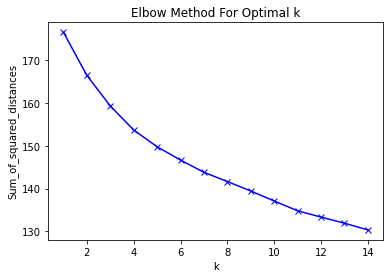

In [140]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 4.2. HDBSCAN

## 5. Conclusions

## Bits of code

In [ ]:
# Get unique street names from the new ppd_london dataframe, remove nan values.
ppd_london_streets = [x for x in ppd_london['Street'].unique() if str(x) != 'nan']
ppd_london_streets[0:10]

## References

How to access HM Land Registry Price Paid Data: https://www.gov.uk/guidance/about-the-price-paid-data

Price Paid Data - HM Land Registry: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

Average private rental prices per borough:https://data.london.gov.uk/dataset/average-private-rents-borough

Borough property and rental prices - Foxtons: https://www.foxtons.co.uk/living-in/bermondsey

List of London boroughs : https://en.wikipedia.org/wiki/List_of_London_boroughs